# Projet Datascientest | DST_DEC22 | Rapport d'exploration

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Date du document** : 2023/01/23

## Contexte et objectif

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.


## Data exploration

### Import des bibliotèques Python

L'analyse exploratoire se base sur les biliothèques suivantes :

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys  

sns.set_style("whitegrid")
sys.path.insert(0, '..') #Pour inclure le dossier parent à report
%matplotlib inline

import src.commons as commons

### Import des données d'entrainement et de test

Les données fournies pour ce challenge sont les suivantes :
* `X_train_update.csv` : données explicatives et textuelles pour l'entraînement
* `X_test_update.csv` : données explicatives et textuelles pour les tests
* `Y_train_CVw08PX` : variable cible pour l'entraînement
* `images/image_train/*.jpg` : images pour l'entraînement
* `images/image_test/*.jpg` :  images pour les tests

> Toutes les images fournies sont au format `.jpg` 

> S'agissant d'un challenge, la variable cible de test n'est pas disponible. Les observations de test fournies ne peuvent donc être utilisées.

Sur la base de ces données, nous pouvons remarquer que deux jeux sont à notre disposition et que leur traitement sera réalisé en parallèle: 
* données textuelles
* données graphiques

In [2]:
#Import des données textuelles et des targets
df_text = commons.read_pkl(name="df_text.pkl", folder="../data/original")    
df_y = commons.read_pkl(name="df_y.pkl", folder="../data/original")    

#Import de la variable cible
df_image = commons.read_pkl(name="df_image.pkl", folder="../data/feature-engineering") 

### Analyse de la forme des datasets

La première étape est celle de l'analyse globale de nos données. 

* Taille de `df_text` : 84 916 x 4
* Nombre d'images dans `image_train` : 84 916
* Taille de `dy_y`       : 84 916 x 1

Les nombres d'images correspondent bien aux nombres d'observations. Au total, 84 916 produits sont à classer. 

> Pour information, les données de test fournies représentaient ~15% des données à notre disposition. Nous respecterons donc ce ratio lors de la séparation de nos dataframes.

In [3]:
_, _, images = next(os.walk('../data/downloaded/images/image_train/'))

print(f"Taille de df_text_train : {df_text.shape}")
print(f"Nombre d'images dans image_train : {len(images)}")
print(f"Taille de df_y : {df_y.shape}")

Taille de df_text_train : (84916, 6)
Nombre d'images dans image_train : 84916
Taille de df_y : (84916, 2)


### Analyse des données

Nous allons maintenant analyser plus en détails les observations.

#### Description des données textuelles

Notre dataset de texte est composé de plusieurs colonnes :

* `designation` (pour df_text_x)
* `description` (pour df_text_x)
* `imageid` (pour df_text_x)
* `prdtypecode` (pour y_x)

Les caractéristiques de chacune de ces colonnes sont données ci-dessous :

**designation** : 

* Type : feature
* Description : titre du produit dans différentes langues
* Disponibilité : oui
* Type informatique : object (text)
* Taux de NaN : 0.0% de NaNs
* Gestion des NaN : pas de suppression ni de remplacement
* Distribution des valeurs : 96.9% de valeurs uniques (en ignorant les NaNs)
* Regroupement de valeurs : scission, extraction des mots
* Pertinence métier de la variable : élevée
* Fiabilité de la méthode d'acquisition	: élevée

**description** : 

* Type : feature
* Description : description du produit dans différentes langues
* Disponibilité : oui
* Type informatique : object (text)
* Taux de NaN : 35.1% de NaNs
* Gestion des NaN : l'abscence de description n'est pas problématique
* Distribution des valeurs : 86.1% de valeurs uniques (en ignorant les NaNs)
* Pertinence métier de la variable : élevée
* Fiabilité de la méthode d'acquisition	: élevée	
* Remarques sur la colonne : contient des balises html

**imageid** : 
* Type : numéro unique, pas vraiment un feature mais plutôt un lien 
* Description : lien vers l'image correspondant au produit
* Disponibilité : oui
* Type informatique : int64


**prdtypecode** : 
* Type : target
* Description : catégorie
* Disponibilité : non
* Type informatique : int64
* Taux de NaN : 0.00%
* Étendue des valeurs : 27 catégories
* Relation entre les valeurs : non
* Équilibre : catégorie 2583 surreprésentée
* Regroupement de valeurs : non
* Pertinence métier de la variable : élevée
* Fiabilité de la méthode d'acquisition	: élevée

#### Description des données graphiques

Comme expliqué, la colonne `imageid` est un lien vers une image. Chaque produit dispose d'une seule image servant à le décrire.

**images**
* Type : images
* Description : image associée au produit
* Une image par produit
* Image en couleur
* Canvas de taille 500x500 sur 3 canaux RGB
* Image de taille variable à l'intérieur du canvas
* Fond souvent blanc, pas toujours le cas
* L'objet peut être accompagné d'autres formes perturbatrices (mains ou  doigts par exemple)

### Analyse du problème

#### Type de problème

Les observations textuelles et graphiques doivent permettre au modèle d'affecter à chaque observation dont les features sont actuellement (`designation`, `description` , et une image) à une catégorie de produit `prdtypecode`. Cette cible est disponible et se présente sous la forme d'un numéro associé à une catégorie (par exemple `livre`, `tech`, `décoration`, etc.).

Nous avons donc affaire à un problème de catégorisation supervisé. Pour la partie texte, un analyse automatique du langage naturel (*NLP : Natural Langage Processing*) sera à mettre en place.

#### Particularité du problème

La catégorisation se base sur l'apprentissage fait sur les données à notre disposition. Ces données sont de deux types (textuel et graphique). De ce fait :
* les pré-traitements seront différents
* plusieurs modèles seront à concevoir, à entrainer et à faire dialoguer
    * un modèle pour catégoriser le produit en fonction du texte fourni
    * un modèle pour catégrosier le produit en fonction de son image associée
    * une étape de regroupement des prédictions sera à réaliser afin d'obtenir une unique catégorie en fin de process



## Feature engineering

Seules deux colonnes et une images sont à notre disposition pour catégoriser notre produit. Afin d'extraire un maximum de données de ces variables, plusieurs pistes peuvent être envisagées : 

**Données textuelles**
* transformer les catégories en description
* calculer les longueurs des textes pour `designation` et `description`
* calculer le nombre de mots pour `designation` et `description`
* fusionner ces deux colonnes dans `text`
* détecter la langue dans `text`
* nettoyer les données :
    * supprimer la ponctuation
    * supprimer les caractères spéciaux
    * supprimer les valeurs numériques
    * supprimer les majuscules
    * supprimer les balises html
    * supprimer les *stopwords*
    * extraire la racine des mots
    * étudier la fréquence d'apparition des mots
    * extraire les *n-gramm*

**Données graphiques**
* calculer le taux de blanc
* calculer la moyenne des canaux

**Augmentation du dataset**
    * augmentation des données visuelles
    * rotation
    * flou
    * miroir horizontal / vetical
    * rognage
    * translation
    * zoom

### Feature engineering sur le texte

La première étape est de traduire les valeurs numériques des catégories en description de la catégorie. Cela simplifiera grandement l'interprétation de nos résultats. 

|Numéro de catégorie| Description|
|-------------------|-------------|
| 10 | Libre |
| 40 | Jeu Console |
| 50 | Accessoire Console|
| 60 | Tech |
| 1140 | Figurine |
| 1160 | Carte Collection |
| 1180 | Jeu Plateau |
| 1280 | Déguisement |
| 1281 | Boite de jeu |
| 1300 | Jouet Tech |
| 1301 | Chaussette |
| 1302 | Gadget |
| 1320 | Bébé |
| 1560 | Salon |
| 1920 | Chambre |
| 1940 | Cuisine |
| 2220 | Jeu Manuel |
| 2060 | Chambre enfant |
| 2220 | Animaux |
| 2280 | Affiche |
| 2403 | Vintage |
| 2462 | Jeu oldschool |
| 2522 | Bureautique |
| 2582 | Décoration |
| 2583 | Aquatique |
| 2585 | Soin et Bricolage |
| 2705 | Livre |
| 2905 | Jeu Console 2 |

In [4]:
#Import des données textuelles et des targets
df_text = commons.read_pkl(name="df_text.pkl", folder="../data/feature-engineering") 
df_image = commons.read_pkl(name="df_image.pkl", folder="../data/feature-engineering")    
df_commons = commons.read_pkl(name="df_commons.pkl", folder="../data/feature-engineering")    
df_y = commons.read_pkl(name="df_y.pkl", folder="../data/feature-engineering")

Pour chaque catégorie, plusieurs images sont affichées. Nous pouvons ainsi nommer la catégorie. De plus, certaines images semblent se ressembler dans des catégories différentes (ex : coussins, jeux videos).

/tmp/ipykernel_4586/1678689850.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1, IMAGE_IN_ROW, figsize=(15,15), subplot_kw = dict(xticks=[], yticks=[]))


<Figure size 640x480 with 0 Axes>

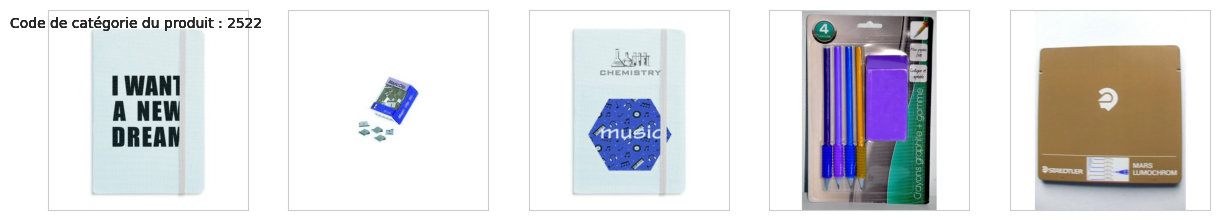

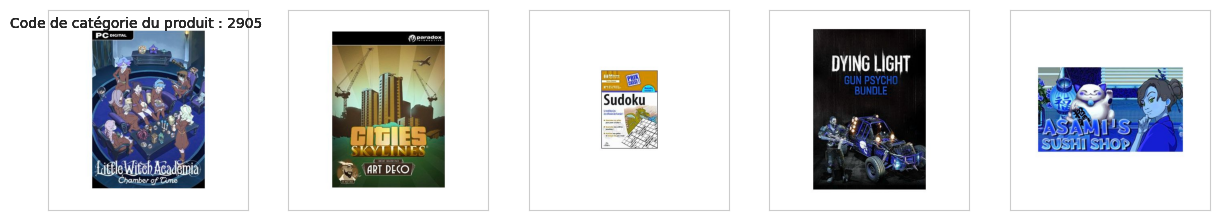

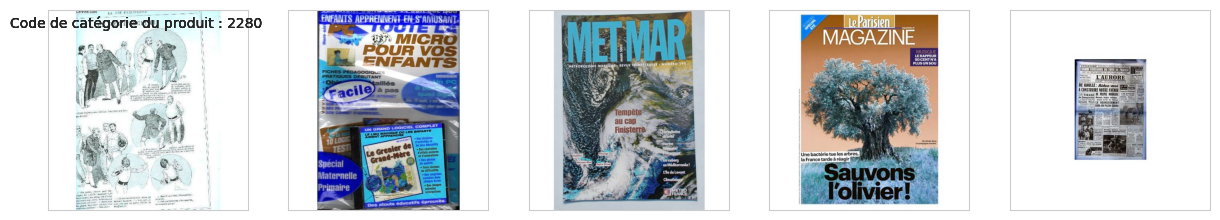

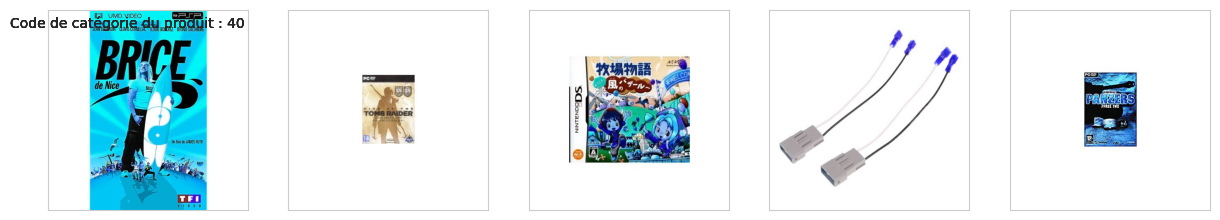

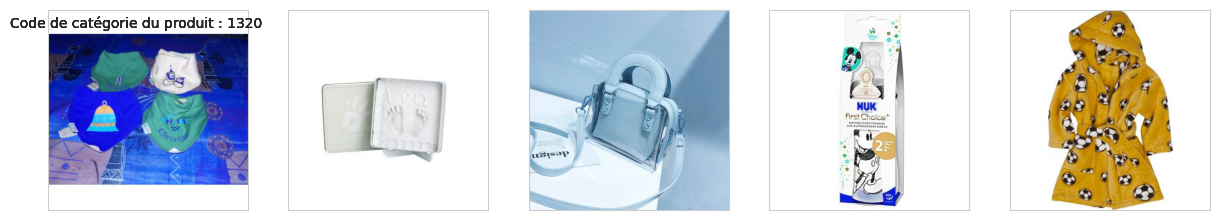

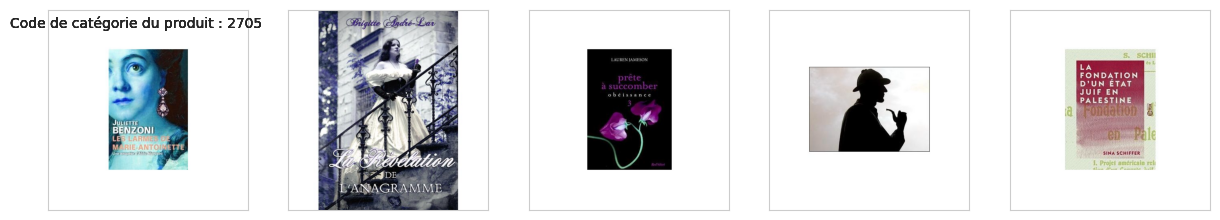

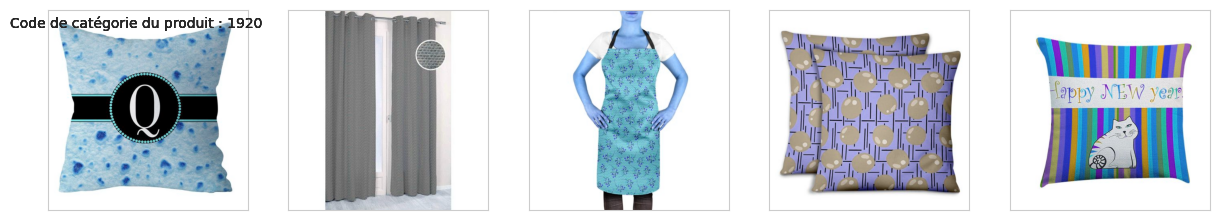

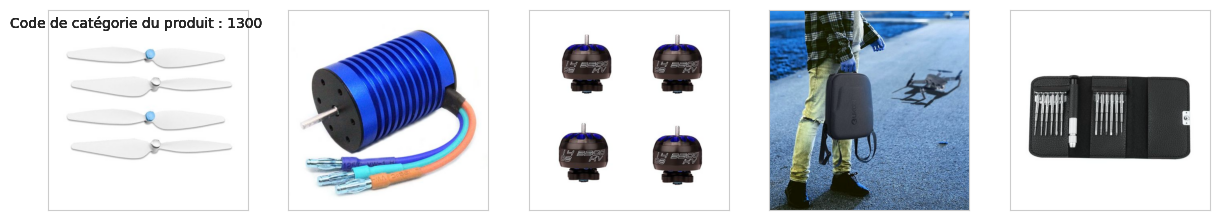

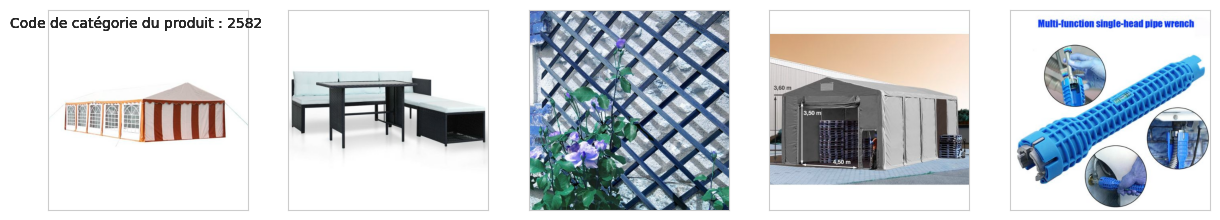

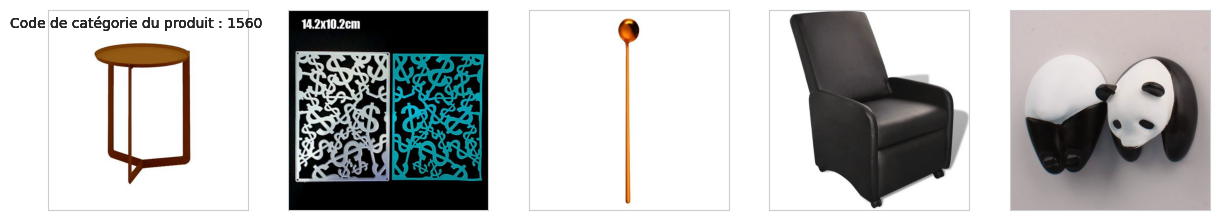

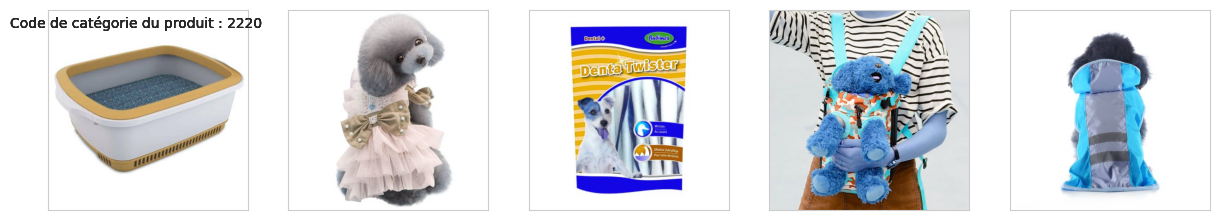

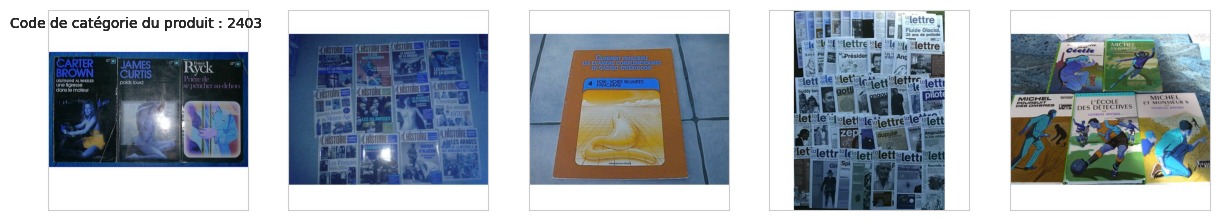

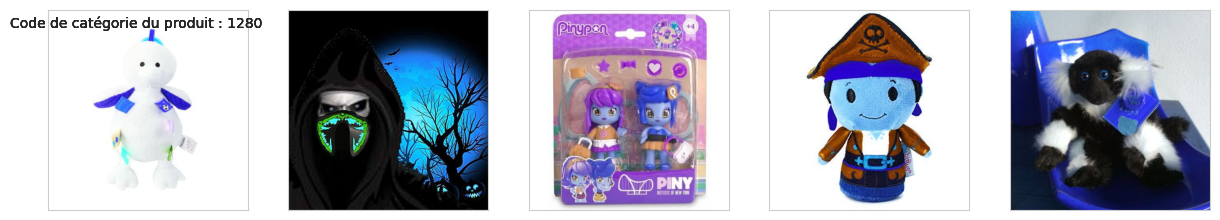

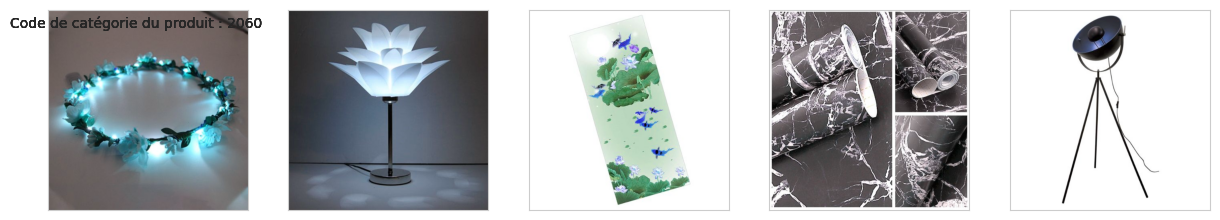

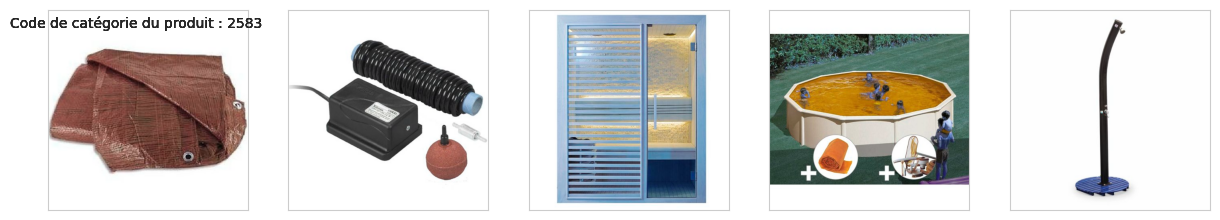

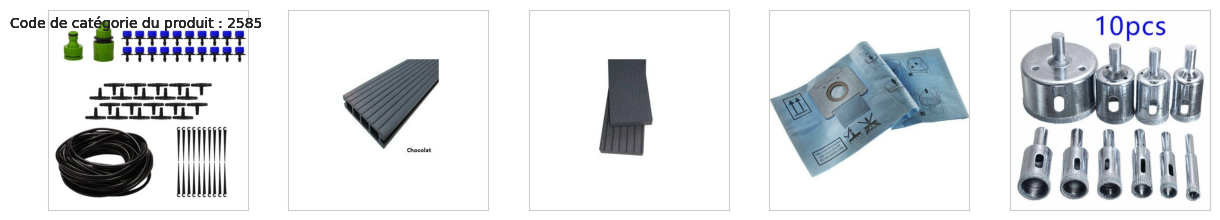

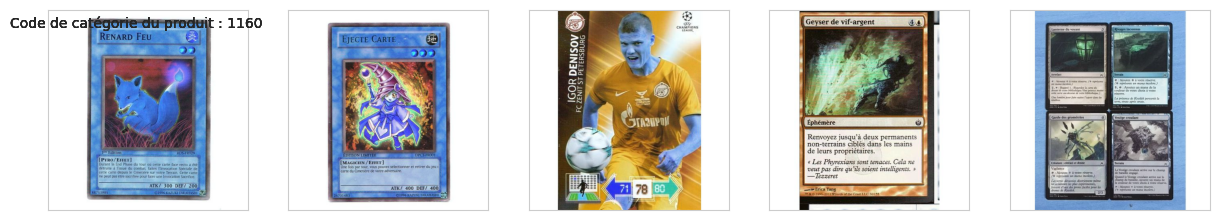

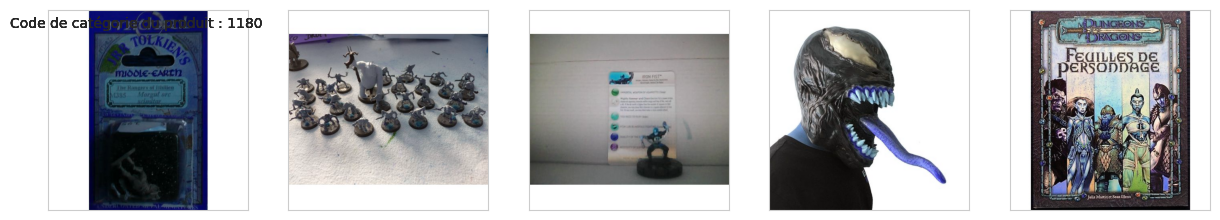

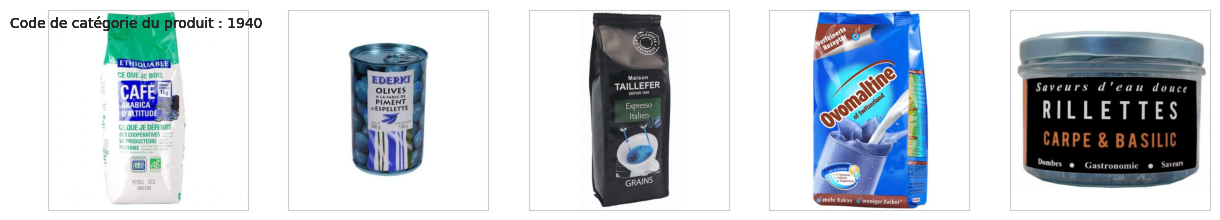

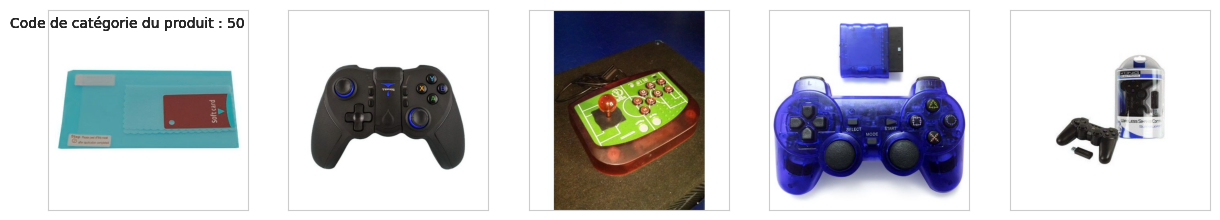

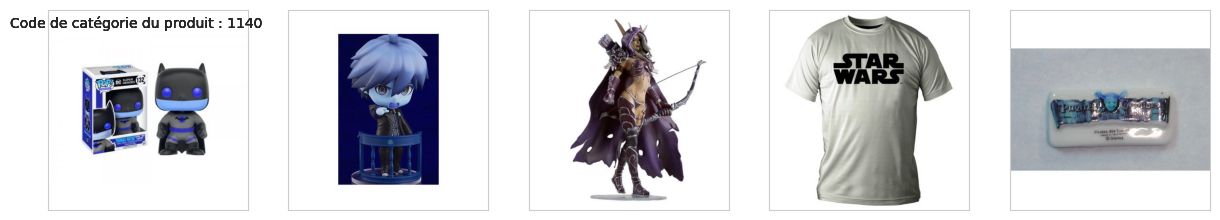

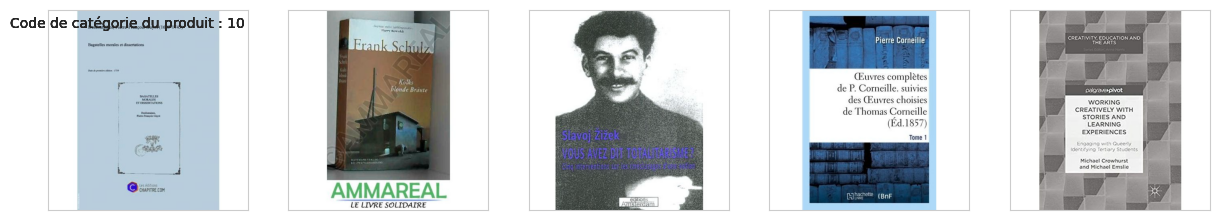

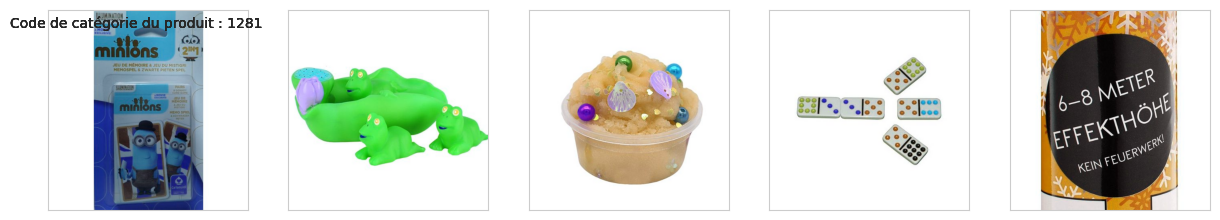

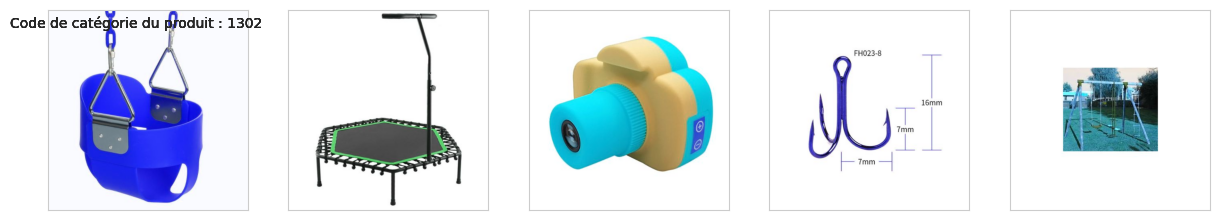

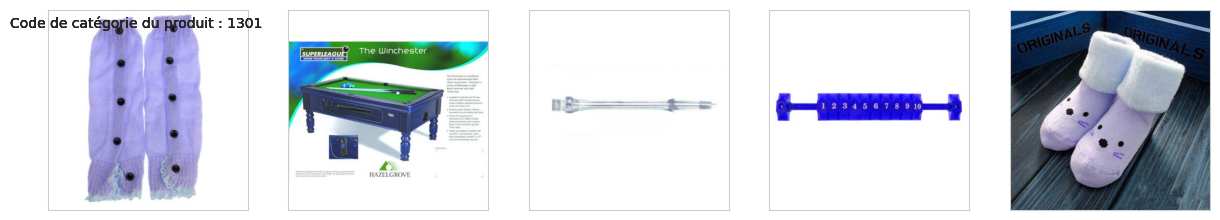

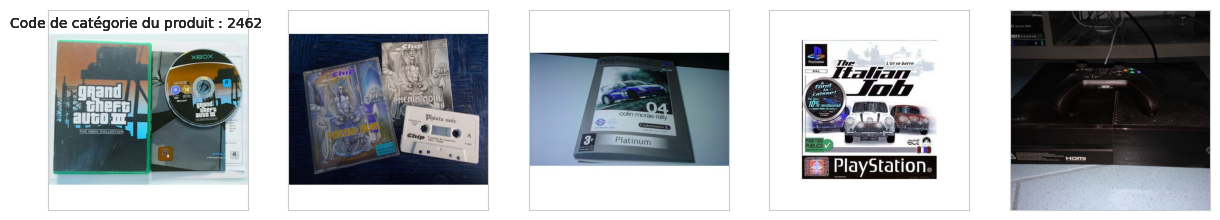

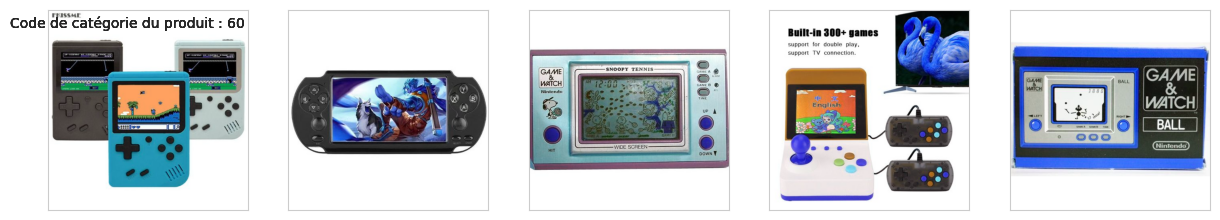

In [5]:
import cv2

IMAGE_IN_ROW = 5

fig = plt.figure()

for unique_category in df_y.prdtypecode.unique():

    f, axarr = plt.subplots(1, IMAGE_IN_ROW, figsize=(15,15), subplot_kw = dict(xticks=[], yticks=[])) 
    images_per_category = df_image.loc[df_image.prdtypecode == unique_category].head(IMAGE_IN_ROW)
    i=0
    for idx, row in images_per_category.iterrows():
        picture = cv2.imread("." + row.links);
        f.text(0.1, 0.55, f'Code de catégorie du produit : {unique_category}')             
        #axarr[i].set_xlabel(productid)
        axarr[i].imshow(picture);
        i+=1

plt.show()

Le graphique ci-dessous montre le nombre de produits pour chacune des 27 catégories. On remarque facilement que la catégorie "Aquatique_" est sur-représentée : elle comporte le double de produits par rapport à la catégorie suivante. On observe également une baisse linéaire du nombre de produits de `Affiche` vers `Accessoire console`. Les catégories de `Cuisine` à `Jeu Console 2` ne présentent que peu d'individus. Il faudra veiller à gérer ce déséquilibre avant d'utiliser notre modèle. 

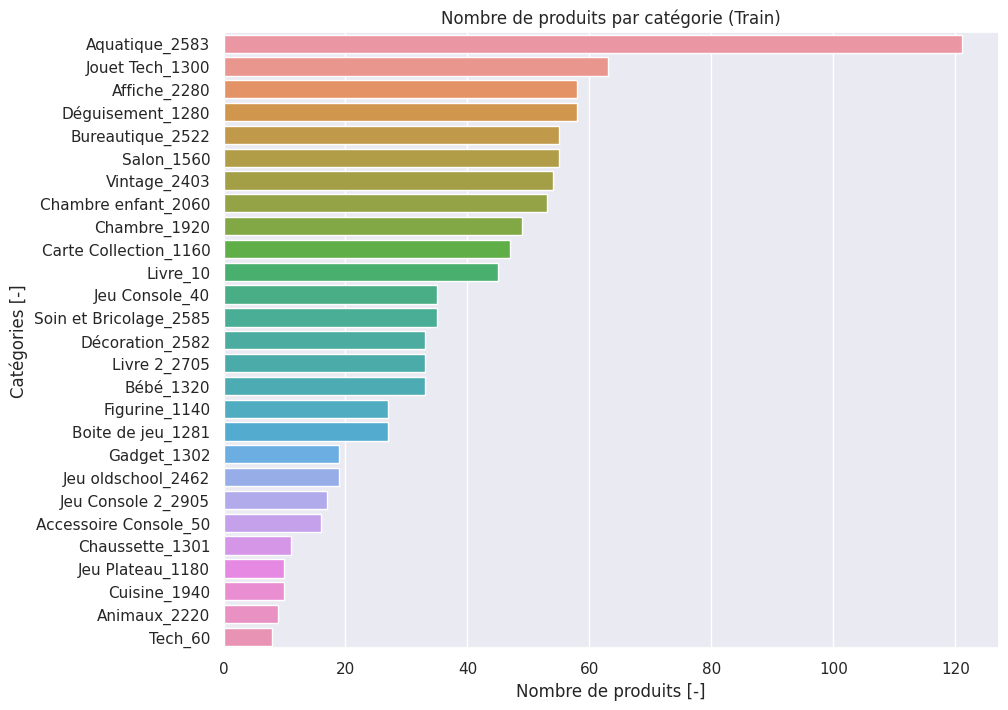

In [6]:
sns.set(rc={'figure.figsize':(10, 8)})
graph_category = sns.countplot(
    data=df_y,
    y="prdtypename",
    order = df_y.prdtypename.value_counts().index);

graph_category.set(
        xlabel='Nombre de produits [-]',
        ylabel='Catégories [-]',
        title='Nombre de produits par catégorie (Train)');




Dans cette étape, nous cherchons à extraire un maximum de données du texte.

- [x] calculer la longueur des textes
- [x] calculer le nombre de mots par texte
- [x] detecter la langue
- [x] supprimer les balises
- [x] supprimer les valeurs numériques
- [x] supprimer les majuscules
- [x] supprimer les *stopwords* en fonction de la langue
- [x] supprimer la ponctuation
- [x] extraire la racine des mots en fonction de la langue
- [x] étudier la fréquence d'apparition des mots
- [x] extraire les *1-gramm*


#### Répartition de la longueur des textes

Pour `designation`, les textes sont composés de 4 à 54 mots. La répartition est de type gaussienne : la moyenne se situe à 11.5 mots et l'écart-type est de 6.4 mots. 75% des textes de `designation` ont moins de 14 mots. 

Pour `description`, les textes plus longs et comportent entre 0 (certaines descriptions sont vides) et 2068 mots. En moyenne, la description se compose d'un texte de 78 mots et 75% des produits sont décrits avec moins de 124 mots. La répartition du nombre de mots suit ici la densité de probabilité d'une loi exponentielle.

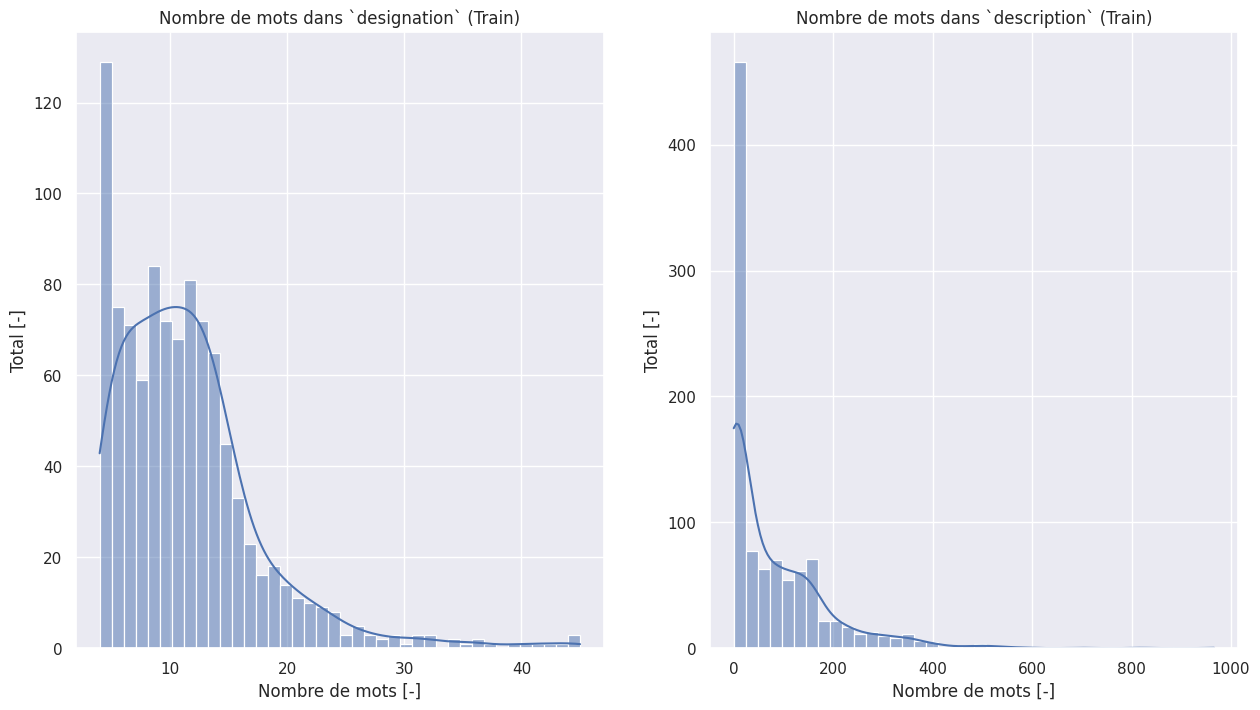

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8));

graph_desig = sns.histplot(
        data=df_text,
        kde=True, 
        bins=40,
        x="desi_num_words",
        ax=axes[0]);

graph_descr = sns.histplot(
        data=df_text,
        kde=True, 
        bins=40,
        x="desc_num_words",
        ax=axes[1]);

graph_desig.set(
        xlabel='Nombre de mots [-]',
        ylabel='Total [-]',
        title='Nombre de mots dans `designation` (Train)');
        
graph_descr.set(
        xlabel='Nombre de mots [-]',
        ylabel='Total [-]',
        title='Nombre de mots dans `description` (Train)');


En affichant également la catégorie associée, nous cherchons à déterminer si la catégorie a un impact sur le nombre de mots de `designation` ou de `description`. Nous utilisons pour cela un `boxplot` pour chaque catégorie, visible ci-dessous. 

Pour `designation`, la catégorie `Affiche` présente une étendue bien supérieure aux autres, tout comme la catégorie `Tech` : il faudra vérifier la composition des descriptions pour ces catégories. Toutes les catégories ont des *outliers*. Les titres de la catégorie `Livre_2` sont quant à eux très limités. Les autres catégories ont des boxplots relativement similaires.

Pour `description`, les *outliers* sont tout aussi nombreux. La catégorie `Jeu_Console_2` a une étendue plus grande que les autres. Certains catégories, comme `Bureautique`, `Carte Collection`, `Affiche`, `Livre`, `Tech`, `Vintage`, `Figurine`, `Jeu oldschool` et `Jeu Plateau` ont des descriptions ne comportant que très peu de mots. 

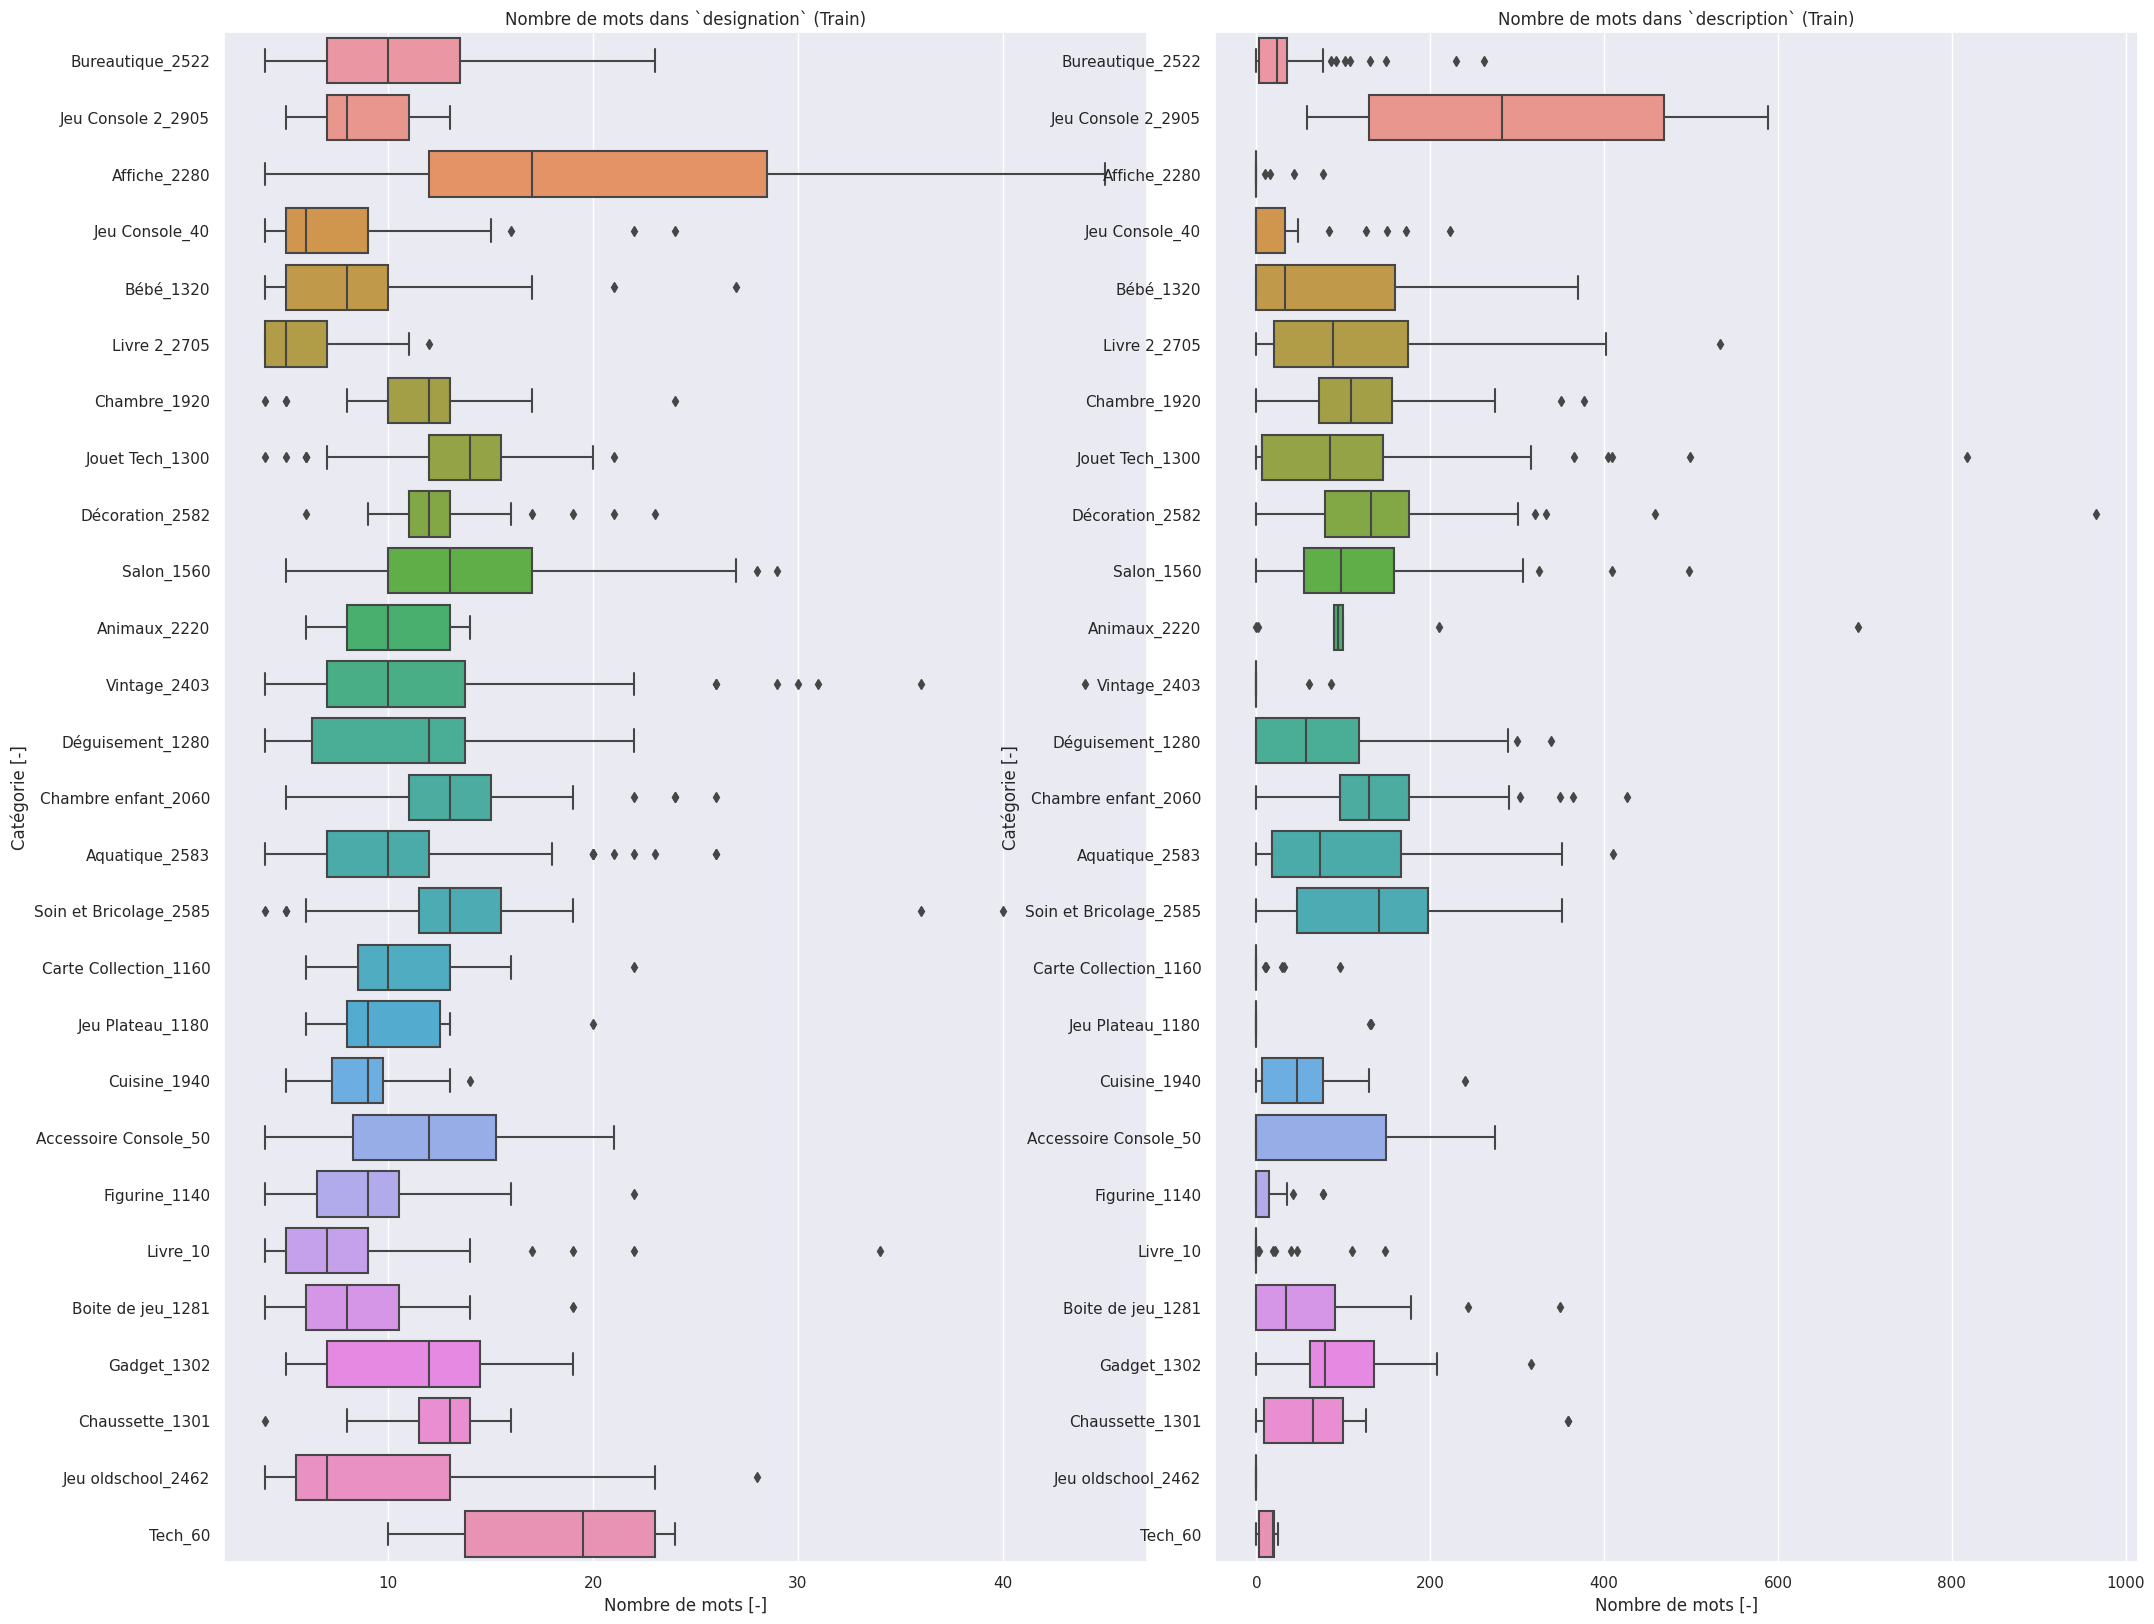

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(20, 16));
fig.tight_layout(h_pad=2)

graph_desig = sns.boxplot(
        data=df_text,
        x="desi_num_words",
        y=df_y.prdtypename,
        ax=axes[0]);

graph_descr = sns.boxplot(
        data=df_text,
        x="desc_num_words",
        y=df_y.prdtypename,
        ax=axes[1]);

graph_desig.set(
        xlabel='Nombre de mots [-]',
        ylabel='Catégorie [-]',
        title='Nombre de mots dans `designation` (Train)');
        
graph_descr.set(
        xlabel='Nombre de mots [-]',
        ylabel='Catégorie [-]',
        title='Nombre de mots dans `description` (Train)');


#### Répartition des langues

Intéressons-nous maintenant à la langue. Les colonnes `designation` et `description` contiennent du texte dont la langue peut varier. Le graphique ci-dessous montre la répartition des langues pour la colonne `designation`. La répartition des langues est très hétérogène :
* 81% en français
* 14% en anglais
* 1.5% en allemand
* inférieurs à 1.5% : nl, ca, it, ro, pt, etc...

Il faudra se poser la question du traitement de cette information :
* Faut-il supprimer les données où la langue n'est pas suffisament utilisée?
* Ou traduire les 15% anglais en francais?

Voici la répartition des 25 premières langues:

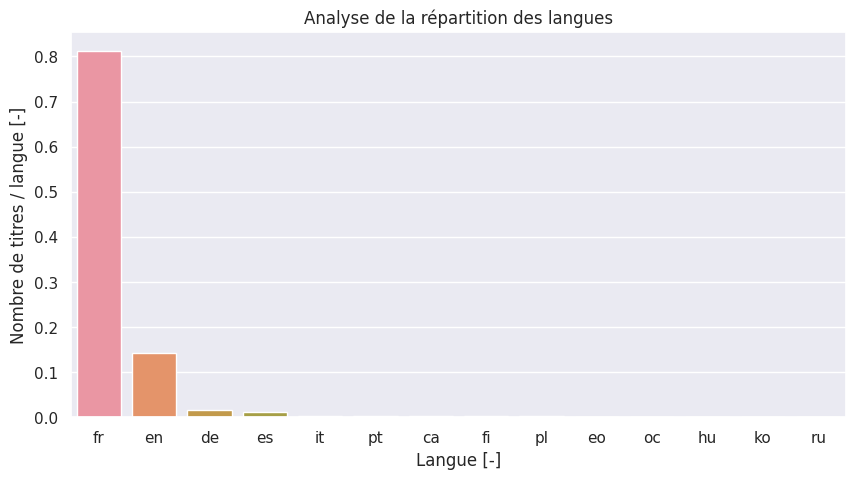

In [9]:
order_lang = df_text.lang.value_counts(normalize=True).sort_values(ascending=False).head(25).reset_index().rename(columns={"index": "lang", "lang": "ratio"})

sns.set(rc={'figure.figsize':(10, 5)})
graph_lang = sns.barplot(
        data = order_lang,
        x="lang",
        y="ratio",
        );

graph_lang.set(
        xlabel='Langue [-]',
        ylabel='Nombre de titres / langue [-]',
        title='Analyse de la répartition des langues');


#### Répartition des mots

L'analyse des mots nous permet de trouver quels sont les mots les plus utilisés dans les textes.

* Les mots `x`, `cm`, `mm`, `taille`, `haut`, `dimens`, `h` et `mesure` font référence à des dimensions
* Les mots `poid` et `g` font référence à des poids

Ici seuls les 50 premiers mots les plus communs sont présentés :
* Le vocabulaire ne semble pas être suffisament riche pour caractériser nos produits
* Les premiers mots sont les plus courants et donc ont de grande chance d'être présents dans de nombreuses catégories ce qui ne nous permettra pas de conclure sur l'appartenance du produit à une catégorie donnée.

Une autre méthode sera à mettre en place afin de trouver les mots caractérisant au mieux nos produits, comme par exemple l'algorithme TF-IDF pour *term frequency-inverse document frequency* afin d'augmenter la pertinence de notre sélection de mots.

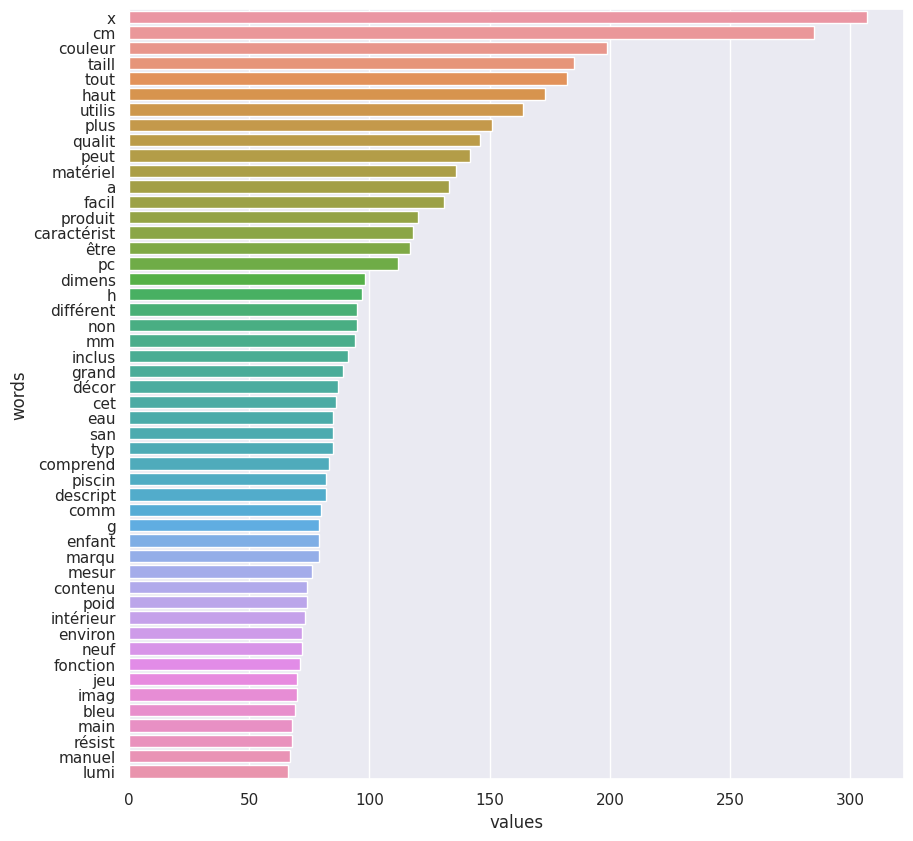

In [10]:
sns.set(rc={'figure.figsize':(10, 10)})
sns.barplot(
    data=df_commons.head(50),
    y="words",
    x="values"
);

### Feature engineering sur les images

* [x] calculer la hauteur et la largeur
* [x] calculer le taux de blanc
* [x] rechercher s'il y a du texte dans les images
* [x] faire un hash des images pour chercher les duplicats
* [x] analyser les moyennes des couleurs de chaque canal


#### Répartition du taux de blanc par catégories

En regroupant les taux de blanc dans les images par catégories, il est possible de distinguer quelques tendances :
* `Jeu Console` et `Accessoire Console` : étendue extrêment faible, images très similaires?
* `Animaux`, `Jeu oldschool`, `Déguisement` : étendue faible

Le taux de blanc est différent selon les catégories et pourrait permettre d'aider le modèle à catégoriser les produits. Il faudra vérifier que ce taux n'introduise pas un biais dans notre modèle, c'est-à-dire que le modèle ne reconnaisse pas une image pour ses formes mais plutôt pour son taux de blanc.

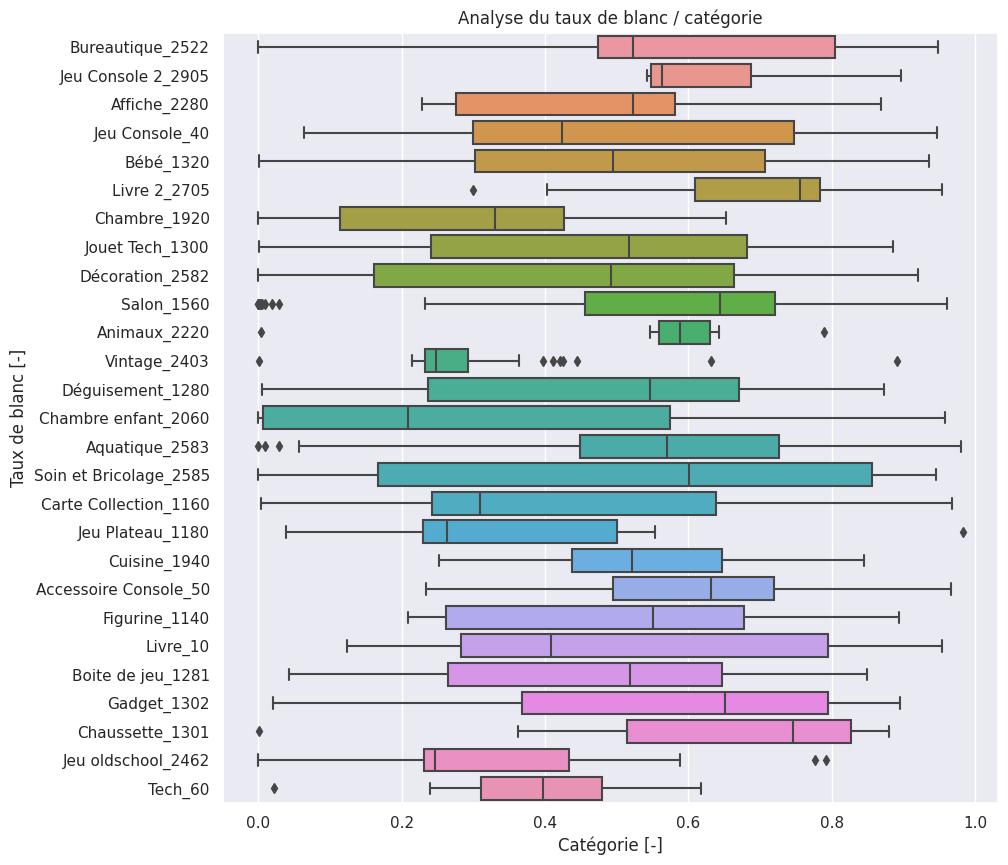

In [11]:
sns.set(rc={'figure.figsize':(10, 10)})
graph_descr = sns.boxplot(
        x=df_image.w_ratios,
        y=df_y.prdtypename);

graph_descr.set(
        xlabel='Catégorie [-]',
        ylabel='Taux de blanc [-]',
        title='Analyse du taux de blanc / catégorie');

#### Répartition de la moyenne des canaux

Dans cette analyse, pour les trois canaux RGB de chaque image, sa moyenne a été extraite. Le graphe ci-dessous présente cette répartition par catégorie.

* L'étendue des moyennes RGB est faible pour les images `Livre_2`,  `Animaux`, `Tech` et `Jeu de plateau` : ces images ont en moyenne une composition RGB similaire.
* A l'inverse, `Chambre enfant` présente un grand intervalle. Les images sont probablement très peu similaires en terme de couleur à l'intérieur de cette catégorie.
* Les répartition des couleurs entre canaux sont globalement proches : aucune catégorie ne présente donc des images totalement rougeâtres ou bleutées.

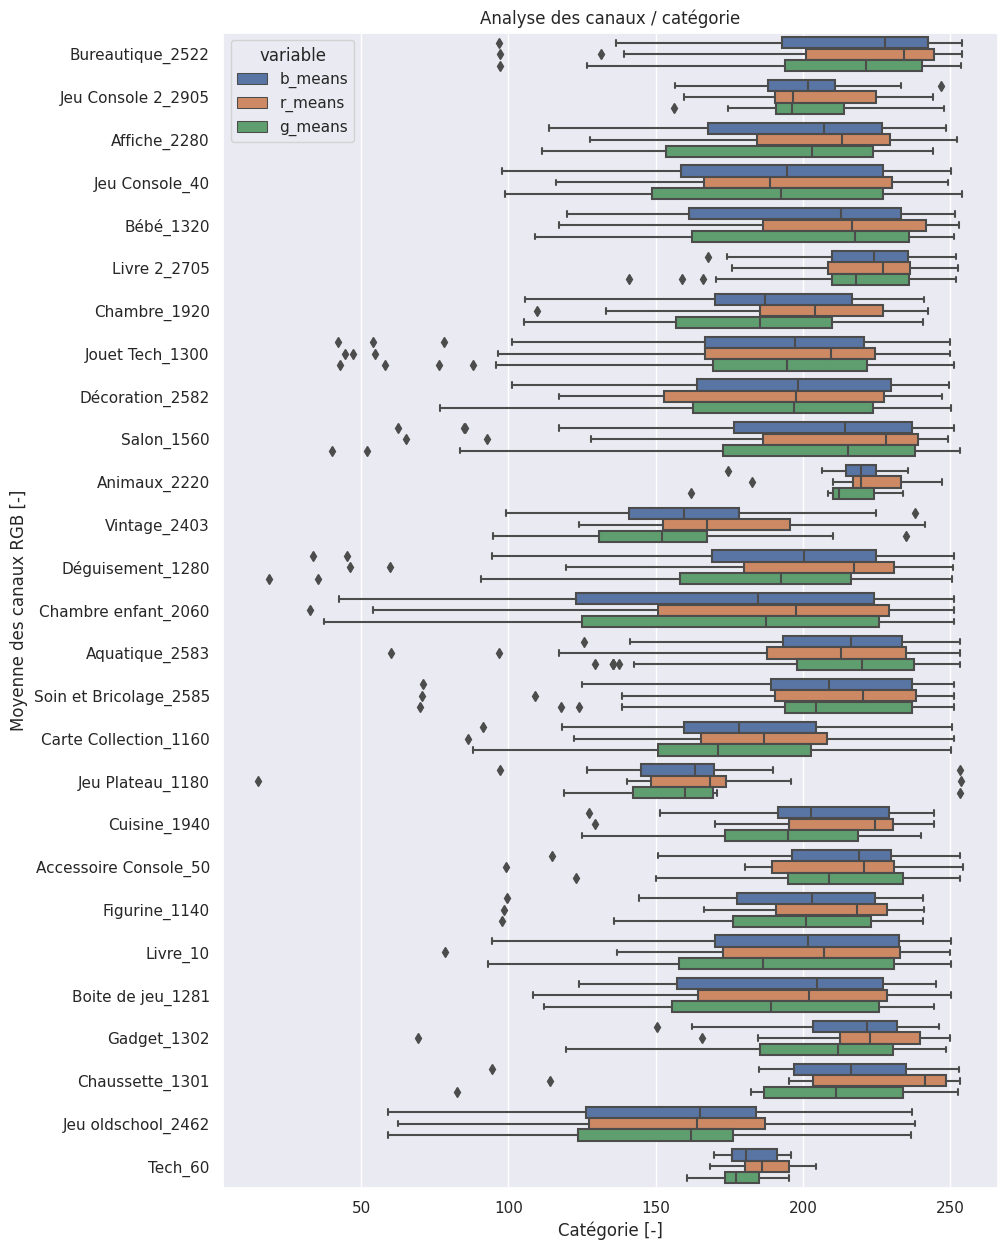

In [12]:
df_rgb = df_image.melt(id_vars=["prdtypename"], value_vars=["b_means", "r_means", "g_means"])
sns.set(rc={'figure.figsize':(10, 15)})
graph_descr = sns.boxplot(
        y=df_rgb.prdtypename,
        x=df_rgb.value, 
        hue=df_rgb.variable);

graph_descr.set(
        xlabel='Catégorie [-]',
        ylabel='Moyenne des canaux RGB [-]',
        title='Analyse des canaux / catégorie');

### Palettes des couleurs

Pour chaque photo, une analyse de la palette des couleurs a été faite : les 12 couleurs dominantes ont été extraites sous forme de code hexadécimal. Ce processus est cependant trop coûteux pour être déployé dans cette première phase d'exploration et de *feature engineering*.

### Challenges

Suite à cette première étude des datasets, plusieurs points ont attiré notre attention : 
* Certaines catégories d'images comprennent des données très similaires
* Certains textes sont très courts
* La target est déséquilibrée
* Les langues sont différentes
* L'aspect de la gestion de mémoire, notamment pour les photos, sera à prendre en compte
* La sélection par mots des plus communs ne semble pas être appropriée

Ces points soulevés seront à garder en mémoire pour la mise en place de nos modèles.